In [1]:
%matplotlib nbagg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import chainer
import chainer.functions as F
import chainer.links as L
import chainer.initializers as I

from ipywidgets import widgets
from ipywidgets.widgets import *
from IPython.display import display

<IPython.core.display.Javascript object>


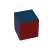

In [2]:
points = np.array([[-1, -1, -1],
                      [1, -1, -1 ],
                      [1, 1, -1],
                      [-1, 1, -1],
                      [-1, -1, 1],
                      [1, -1, 1 ],
                      [1, 1, 1],
                      [-1, 1, 1]])

figsize = 0.5
fig = plt.figure(figsize=(figsize,figsize))
trimwidth = int(figsize * 12)
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111, projection='3d')
r = [-1,1]
X, Y = np.meshgrid(r, r)
ax.plot_surface(X,Y,1)
ax.plot_surface(X,Y,-1)
ax.plot_surface(X,-1,Y)
ax.plot_surface(X,1,Y)
ax.plot_surface(1,X,Y)
ax.plot_surface(-1,X,Y)
plt.axis('off')
def get_yaw(i):
    return i * np.pi / 2 / 5
def get_pitch(i): return i * np.pi / 4 / 5
yaw_angles = get_yaw(np.arange(5))
pitch_angles = get_pitch(np.arange(5))
yaw_mat, pitch_mat = np.meshgrid(yaw_angles, pitch_angles)
images = []
for pitch in pitch_angles:
    for yaw in yaw_angles:
        ax.view_init(pitch * 180 / np.pi, yaw * 180 / np.pi)
        canvas.draw()
        rawimage = np.fromstring(canvas.tostring_rgb(), dtype='uint8')
        image = rawimage.reshape((int(np.sqrt(len(rawimage) // 3)), -1, 3))
        cropimage = image[trimwidth:-trimwidth, trimwidth:-trimwidth, :]
        rawcropimage = np.array(cropimage.flat)
        images.append(rawcropimage)

In [3]:
print(np.array(images).max())

255


(4332,)
(38, 38, 3)


<IPython.core.display.Javascript object>


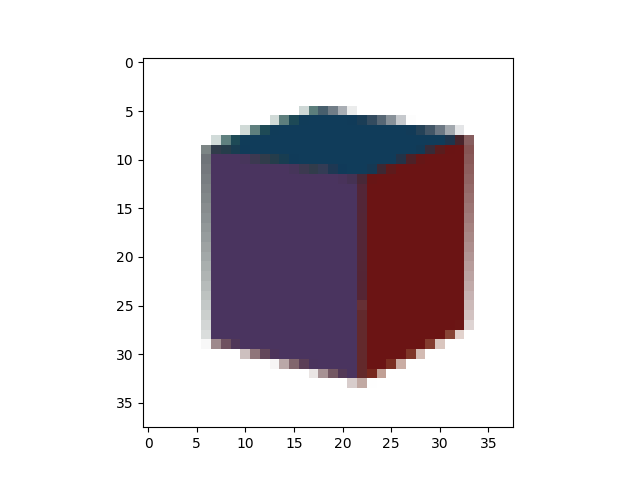

In [3]:
def plotimg(yaw,pitch):
    print(images[yaw + pitch * len(yaw_angles)].shape)
    image = images[yaw + pitch * len(yaw_angles)]
    img = image.reshape((int(np.sqrt(len(image) // 3)), -1, 3))
    print(img.shape)
    plt.imshow(img)
    k = np.arange(50)

interact(plotimg, yaw=(0,len(yaw_angles)-1,1), pitch=(0,len(pitch_angles)-1,1));

In [4]:
class Regressor(chainer.Chain):
    def __init__(self, outputs=1, n_units=128, outputfun=F.sigmoid):
        self.outputfun = outputfun
        super(Regressor, self).__init__(
            l1 = L.Linear(None, n_units),
            l2 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = self.l2(h1)
        return self.outputfun(h2)

In [5]:
class Regressor2(chainer.Chain):
    def __init__(self, outputs=1, n_units=128, outputfun=F.sigmoid):
        self.outputfun = outputfun
        super(Regressor2, self).__init__(
            l1 = L.Linear(None, n_units),
            l2 = L.Linear(n_units, n_units),
            l3 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.outputfun(self.l3(h2))

In [6]:
class Regressor3(chainer.Chain):
    def __init__(self, outputs=1, n_units=128, outputfun=F.sigmoid):
        w = I.Normal(0.005)
        self.outputfun = outputfun
        super(Regressor3, self).__init__(
            l1 = L.Linear(None, n_units, initialW=w),
            l2 = L.Linear(n_units, n_units, initialW=w),
            l3 = L.Linear(n_units, n_units, initialW=w),
            l4 = L.Linear(n_units, outputs, initialW=w)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        return self.outputfun(self.l4(h3))

In [7]:
class CNNRegressor2(chainer.Chain):
    def __init__(self, outputs=1, n_units=128, outputfun=F.sigmoid):
        self.outputfun = outputfun
        super(CNNRegressor2, self).__init__(
            conv1 = L.Convolution2D(None, n_units, ksize=3),
            l2 = L.Linear(n_units, n_units),
            l3 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = self.conv1(x)
        h2 = F.relu(self.l2(h1))
        return self.outputfun(self.l3(h2))

In [8]:
class MyTrainer:
    def __init__(self, regularize=0.0001, model=None, model_class=Regressor3, outputs=1, optimizer=None, outputfun=F.sigmoid, lossfun=F.mean_squared_error):
        self.regularize = regularize
        if model == None:
            model = model_class(outputs, 256, outputfun=outputfun)
            model.zerograds()
        self.model = model
        if optimizer == None:
            optimizer = chainer.optimizers.Adam()
            optimizer.setup(model)
            optimizer.add_hook(chainer.optimizer.WeightDecay(regularize))
        self.optimizer = optimizer
        self.lossfun = lossfun

    def run_train(self, trainx, trainy, epoch=10000, report_period=100, report_period_seconds=0):
        from time import clock
        start = clock()
        last_report = start
        loss_hist = []

        try:
            for i in range(epoch):
                loss = self.lossfun(self.model(trainx), trainy)
                loss_hist.append(loss.data)
                if i % report_period == 0:
                    if last_report + report_period_seconds < clock():
                        ups = i / (clock() - start)
                        eta = (epoch - i) / ups if ups != 0 else 0
                        etas = '%d:%05.2f' % (eta // 60, eta % 60) if 60 < eta else '%.2f' % eta
                        print(i, 'loss', loss.data, ', ups: %.2f' % ups, ', eta: ' + etas)
                        last_report = clock()
                #optimizer.weight_decay(0.005)
                self.optimizer.update(lambda x,y: self.lossfun(self.model(x), y), trainx, trainy)
        except KeyboardInterrupt:
            print('Interrupted')

        return loss_hist

In [9]:
train_mode = 'rowpixels'
if train_mode == 'flat':
    x = y = range(int(np.sqrt(len(images[0]) // 3)))
    print(len(x))
    A, P, X, Y = np.meshgrid(yaw_angles, pitch_angles, x, y)
    print(X.shape, Y.shape, A.shape[0] * A.shape[1] * A.shape[2])
    APXY = np.vstack([A.flat, P.flat, np.array(X.flat), np.array(Y.flat)]).astype(np.float32).T
    trainx = APXY
    print(APXY.shape, 'image: ', images[0].shape)
    imageXY = np.zeros((trainx.shape[0],3))
    i = 0
    for image in images:
        imageXY[i:(i+image.shape[0]//3),:] = image.reshape((-1,3))
        i += image.shape[0]//3
    trainy = np.array(imageXY, dtype=np.float32)
    model_class = Regressor3
    outputfun = lambda x: F.sigmoid(x) * 255
    lossfun = F.mean_squared_error
elif train_mode == 'rowpixels':
    trainx = np.vstack([yaw_mat.flat, pitch_mat.flat]).astype(np.float32).T
    trainy = np.array(images, dtype=np.float32)
    model_class = Regressor3
    outputfun = lambda x: F.sigmoid(x) * 255
    lossfun = F.mean_squared_error
elif train_mode == 'angles':
    trainx = np.array(images, dtype=np.float32)
    trainy = np.vstack([yaw_mat.flat, pitch_mat.flat]).astype(np.float32).T
    model_class = Regressor3
    outputfun = lambda x: F.identity(x)
    lossfun = F.mean_squared_error
else:
    raise Exception('Invalid train_mode')
print(trainx.shape, trainy.shape)


(25, 2) (25, 4332)


In [10]:
trainer = MyTrainer(regularize=0.0000, model_class=model_class, outputs=trainy.shape[1], outputfun=outputfun, lossfun=lossfun)

In [19]:
loss_hist = trainer.run_train(trainx, trainy, epoch=200, report_period=10, report_period_seconds=1)

10 loss 1372.8382568359375 , ups: 2.48 , eta: 1:16.61
20 loss 1370.2359619140625 , ups: 2.15 , eta: 1:23.78
30 loss 1367.5074462890625 , ups: 2.04 , eta: 1:23.14
40 loss 1364.6368408203125 , ups: 1.92 , eta: 1:23.27
50 loss 1361.6014404296875 , ups: 1.80 , eta: 1:23.23
60 loss 1358.38232421875 , ups: 1.91 , eta: 1:13.46
70 loss 1354.959228515625 , ups: 1.90 , eta: 1:08.42
80 loss 1351.2996826171875 , ups: 1.93 , eta: 1:02.19
90 loss 1347.3836669921875 , ups: 2.00 , eta: 54.94
100 loss 1343.1798095703125 , ups: 1.90 , eta: 52.61
110 loss 1338.658935546875 , ups: 1.79 , eta: 50.29
120 loss 1333.7958984375 , ups: 1.71 , eta: 46.65
130 loss 1328.5560302734375 , ups: 1.67 , eta: 41.98
140 loss 1322.913330078125 , ups: 1.67 , eta: 36.02
150 loss 1316.8375244140625 , ups: 1.67 , eta: 29.88
160 loss 1310.2947998046875 , ups: 1.65 , eta: 24.21
170 loss 1303.251953125 , ups: 1.65 , eta: 18.13
180 loss 1295.6705322265625 , ups: 1.63 , eta: 12.29
190 loss 1287.497802734375 , ups: 1.64 , eta: 6.12


In [239]:
chainer.serializers.save_npz("result/image3d2_25px.model", trainer.model)

<IPython.core.display.Javascript object>


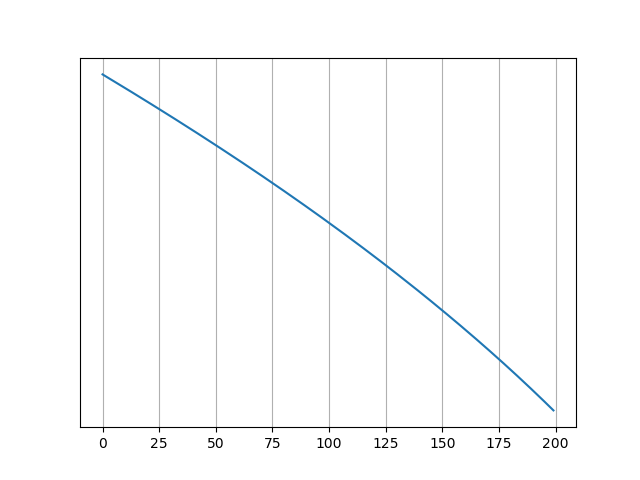

In [17]:
plt.semilogy(loss_hist)
plt.grid()

<IPython.core.display.Javascript object>


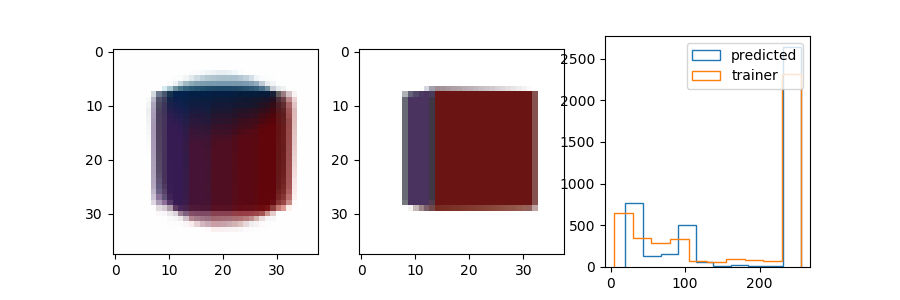

In [18]:
def plotimg(yaw,pitch,image_only=False,ax=None):
    predicted = trainer.model(np.array([get_yaw(yaw), get_pitch(pitch)], dtype=np.float32)[np.newaxis]).data
    print(predicted.shape, predicted.min(), predicted.max())
    xs = int(np.sqrt(predicted.shape[1] // 3))
    img = predicted.reshape((xs, -1, 3))
    if image_only:
        return plt.imshow(img / 255)
    else:
        if ax == None:
            fig, ax = plt.subplots(1, 3, figsize=(9,3))
        for a in ax: a.clear()
        ax[0].imshow(img / 255)
        iyaw = int(yaw)
        ipitch = int(pitch)
        if 0 <= iyaw and iyaw < len(yaw_angles) and 0 <= ipitch and ipitch < len(pitch_angles):
            image = images[iyaw + ipitch * len(yaw_angles)]
            img2 = image.reshape((int(np.sqrt(len(image) // 3)), -1, 3))
            ax[1].imshow(img2)
            ax[2].hist(img2.flat, histtype='step')
        ax[2].hist(predicted.flat, histtype='step')
        ax[2].legend(['predicted', 'trainer'])

interactive = False
if interactive:
    interact(lambda yaw,pitch: plotimg(yaw,pitch), yaw=(-10,len(yaw_angles)+10,1), pitch=(-10,len(pitch_angles)+10,1));
else:
    import matplotlib.animation as animation
    fig, ax = plt.subplots(1, 3, figsize=(9,3))
    supersample = 5

    def img_init():
        pass

    def img_animate(i):
        yaw = (i / supersample) % len(yaw_angles)
        pitch = np.floor((i / supersample) / len(yaw_angles)) / supersample
        print(pitch, yaw)
        plotimg(yaw, pitch, ax=ax)
        #xx = np.arange(0, 10, 0.01)
        #im = plt.plot(xx, pitch * np.sin(yaw * xx), "r")
        #ims.append(im)
    #print(len(ims))
    #ani = animation.ArtistAnimation(fig, ims)
    ani = animation.FuncAnimation(fig, img_animate, init_func=img_init,
                               frames=len(pitch_angles)*len(yaw_angles)*(supersample**2), interval=100, blit=True)
    #HTML(ani.to_html5_video())
    #plt.show()

<IPython.core.display.Javascript object>


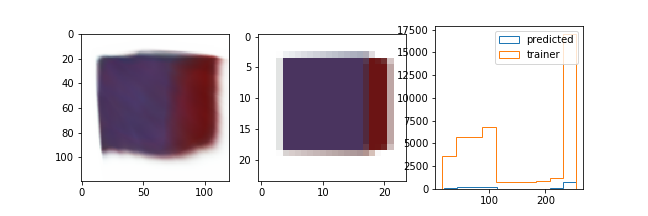

In [245]:
def plotimg(yaw,pitch,image_only=False,ax=None):
    def upsample(x): return np.linspace(min(x),max(x),len(x)*5)
    X, Y = np.meshgrid(upsample(x), upsample(y))
    print(X.shape, len(x), y)
    XYA = np.vstack([np.ones(X.shape[0] * X.shape[1]) * get_yaw(yaw),
                     np.ones(X.shape[0] * X.shape[1]) * get_pitch(pitch),
                     np.array(X.flat), np.array(Y.flat)]).astype(np.float32).T
    predicted = trainer.model(XYA).data
    xs = X.shape[0]
    print(predicted.shape, xs, predicted.shape[0] // (3 * xs))
    img = predicted.reshape((xs, -1, 3)).transpose((1,0,2))
    #print(img.shape)
    if image_only:
        return plt.imshow(img / 255)
    else:
        if ax == None:
            fig, ax = plt.subplots(1, 3, figsize=(9,3))
        for a in ax: a.clear()
        ax[0].imshow(img / 255)
        iyaw = int(yaw)
        ipitch = int(pitch)
        if 0 <= iyaw and iyaw < len(yaw_angles) and 0 <= ipitch and ipitch < len(pitch_angles):
            image = images[iyaw + ipitch * len(yaw_angles)]
            img2 = image.reshape((int(np.sqrt(len(image) // 3)), -1, 3))
            ax[1].imshow(img2)
            ax[2].hist(img2.flat, histtype='step')
        ax[2].hist(predicted.flat, histtype='step')
        ax[2].legend(['predicted', 'trainer'])

interactive = False
if interactive:
    interact(lambda yaw,pitch: plotimg(yaw,pitch), yaw=(0,len(yaw_angles)-1,0.5), pitch=(0,len(pitch_angles)-1,0.5));
else:
    import matplotlib.animation as animation
    fig, ax = plt.subplots(1, 3, figsize=(9,3))
    supersample = 3

    def img_init():
        pass

    def img_animate(i):
        yaw = (i / supersample) % len(yaw_angles)
        pitch = np.floor((i / supersample) / len(yaw_angles)) / supersample
        print(pitch, yaw)
        plotimg(yaw, pitch, ax=ax)
        #xx = np.arange(0, 10, 0.01)
        #im = plt.plot(xx, pitch * np.sin(yaw * xx), "r")
        #ims.append(im)
    #print(len(ims))
    #ani = animation.ArtistAnimation(fig, ims)
    ani = animation.FuncAnimation(fig, img_animate, init_func=img_init,
                               frames=len(pitch_angles)*len(yaw_angles)*(supersample**2), interval=100, blit=True)
    #HTML(ani.to_html5_video())
    #plt.show()

0.00443387031555 0.999991297722
max yaw residue:  0.256709540684 24
max pitch residue:  0.00948160886765 1
[[  1.08373165e-03   3.09873402e-01   6.23629689e-01   9.40318108e-01
    9.99974489e-01]
 [  5.39004803e-04   3.11092138e-01   6.24913692e-01   9.41172302e-01
    9.99991298e-01]
 [  1.33320689e-03   3.12009096e-01   6.26109600e-01   9.40851569e-01
    9.99986053e-01]
 [  2.67353654e-03   3.11824173e-01   6.25549078e-01   9.42389488e-01
    9.99979377e-01]
 [  2.79414654e-03   3.12418878e-01   6.26740336e-01   9.41320419e-01
    9.99927521e-01]] [ 0.          0.31415927  0.62831853  0.9424778   1.25663706]
[[ 0.00443387  0.00948161  0.00779644  0.00568014  0.00683421]
 [ 0.15683955  0.15578699  0.15639281  0.15640241  0.15612912]
 [ 0.31451729  0.31453544  0.31491983  0.31430423  0.31418711]
 [ 0.47216874  0.47157258  0.47143933  0.47113818  0.47129464]
 [ 0.62878698  0.6286425   0.62836063  0.62820256  0.62836534]] [ 0.          0.15707963  0.31415927  0.4712389   0.62831853]


<IPython.core.display.Javascript object>


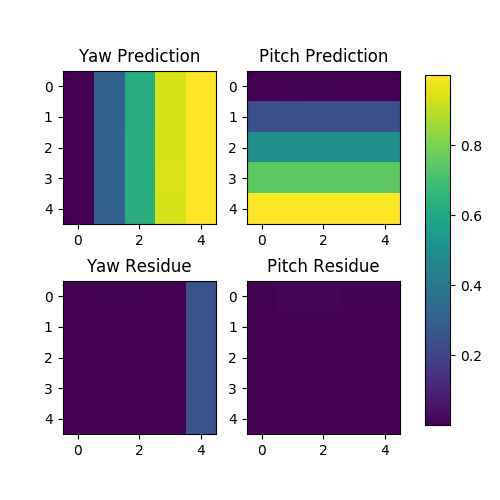

In [151]:
predicted_angles = np.zeros((len(pitch_angles), len(yaw_angles), 2))
for ipitch in range(len(pitch_angles)):
    for iyaw in range(len(yaw_angles)):
        image = images[iyaw + ipitch * len(yaw_angles)][np.newaxis]
        #print(image.shape, model.l1)
        predicted = trainer.model(image.astype(np.float32)).data
        #print(image.mean(), predicted.shape, trainy[iyaw + ipitch * len(yaw_angles)], predicted)
        predicted_angles[ipitch, iyaw, :] = predicted

print(predicted_angles[:,:,1].min(), predicted_angles[:,:,0].max())
yaw_residue = predicted_angles[:,:,0] - yaw_angles.reshape((1,-1))
print('max yaw residue: ', abs(yaw_residue).max(), abs(yaw_residue).argmax())
pitch_residue = predicted_angles[:,:,1] - pitch_angles.reshape((-1,1))
print('max pitch residue: ', abs(pitch_residue).max(), abs(pitch_residue).argmax())
print(predicted_angles[:,:,0], yaw_angles)
print(predicted_angles[:,:,1], pitch_angles)

fig, ax = plt.subplots(2,2,figsize=(5,5))
def subimshow(ax,im):
    im = ax.pcolormesh(im)
    ax.imshow(im)
    fig.colorbar(im, ax=ax)
im = ax[0,0].imshow(predicted_angles[:,:,0])
ax[0,0].set_title('Yaw Prediction')
ax[0,1].imshow(predicted_angles[:,:,1])
ax[0,1].set_title('Pitch Prediction')
ax[1,0].imshow(abs(yaw_residue), vmin=0, vmax=predicted_angles[:,:,0].max())
ax[1,0].set_title('Yaw Residue')
ax[1,1].imshow(abs(pitch_residue), vmin=0, vmax=predicted_angles[:,:,1].max())
ax[1,1].set_title('Pitch Residue')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax);